In [1]:
import random
import inspect
import copy
import numpy as np
import torch
import dgl
import networkx as nx
import torch.nn.functional as F
import argparse
from sklearn.metrics import precision_score, recall_score, f1_score
from gat import GAT
from dgl.data.ppi import LegacyPPIDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
%notebook inline
def collate(sample):
    graphs, feats, labels =map(list, zip(*sample))
    graph = dgl.batch(graphs)
    feats = torch.from_numpy(np.concatenate(feats))
    labels = torch.from_numpy(np.concatenate(labels))
    return graph, feats, labels

def evaluate(feats, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.g = subgraph
        for layer in model.gat_layers:
            layer.g = subgraph
        output = model(feats.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        precision = precision_score(labels.data.cpu().numpy(),
                         predict, average='micro')
        recall = recall_score(labels.data.cpu().numpy(),
                         predict, average='micro')
        score = f1_score(labels.data.cpu().numpy(),
                         predict, average='micro')
        return precision, recall, score, loss_data.item()

def modify(curr_dataset, train_dataset, curr_list, mode='train', offset=0):
    tmp_curr_graphs = [train_dataset.train_graphs[i] for i in curr_list]
    tmp_mask_list = [train_dataset.train_mask_list[i] for i in curr_list]

    tmp_graph = dgl.batch(tmp_curr_graphs)
    node_num_list = tmp_graph.batch_num_nodes

    lst = []
    for index, val in enumerate(node_num_list):
        lst = lst + list([offset + index + 1] * val)
    tmp_graph_id = np.array([lst])

    ind_list = tmp_mask_list[0]
    for i in range(1, len(tmp_mask_list)):
        ind_list = np.concatenate((ind_list, tmp_mask_list[i]), axis=None)
    
    tmp_labels = train_dataset.labels[ind_list, :]
    tmp_features = train_dataset.features[ind_list, :]

    curr_nodes = node_num_list[0]
    tmp_curr_mask_list = [np.array(list(range(curr_nodes)))]
    tmp_curr_labels = [tmp_labels[tmp_curr_mask_list[0], :]]
    for i in range(1, len(node_num_list)):
        curr = np.array(list(range(curr_nodes, curr_nodes + node_num_list[i])))
        curr_nodes += node_num_list[i]
        tmp_curr_mask_list.append(curr)
        tmp_curr_labels.append(tmp_labels[curr, :])

    curr_dataset.labels = tmp_labels
    curr_dataset.features = tmp_features
    curr_dataset.graph_id = tmp_graph_id
    curr_dataset.graph = tmp_graph
    if mode == 'valid':
        curr_dataset.valid_mask_list = tmp_curr_mask_list
        curr_dataset.valid_graphs = tmp_curr_graphs
        curr_dataset.valid_labels = tmp_curr_labels
    else:
        curr_dataset.train_mask_list = tmp_curr_mask_list
        curr_dataset.train_graphs = tmp_curr_graphs
        curr_dataset.train_labels = tmp_curr_labels
    
    return

In [3]:
def argparser():
    parser = argparse.ArgumentParser(description='GAT')
    parser.add_argument("--gpu", type=int, default=-1,
                        help="which GPU to use. Set -1 to use CPU.")
    parser.add_argument("--epochs", type=int, default=400,
                        help="number of training epochs")
    parser.add_argument("--num-heads", type=int, default=4,
                        help="number of hidden attention heads")
    parser.add_argument("--num-out-heads", type=int, default=6,
                        help="number of output attention heads")
    parser.add_argument("--num-layers", type=int, default=2,
                        help="number of hidden layers")
    parser.add_argument("--num-hidden", type=int, default=256,
                        help="number of hidden units")
    parser.add_argument("--residual", action="store_true", default=True,
                        help="use residual connection")
    parser.add_argument("--in-drop", type=float, default=0,
                        help="input feature dropout")
    parser.add_argument("--attn-drop", type=float, default=0,
                        help="attention dropout")
    parser.add_argument("--lr", type=float, default=0.005,
                        help="learning rate")
    parser.add_argument('--weight-decay', type=float, default=0,
                        help="weight decay")
    parser.add_argument('--alpha', type=float, default=0.2,
                        help="the negative slop of leaky relu")
    parser.add_argument('--batch-size', type=int, default=2,
                        help="batch size used for training, validation and test")
    parser.add_argument('--patience', type=int, default=10,
                        help="used for early stop")
    args = parser.parse_args('--gpu 0 --num-layers 3 --epochs 400 --patience 20'.split())
    print(args)
    return args

In [4]:
args = argparser()

Namespace(alpha=0.2, attn_drop=0, batch_size=2, epochs=400, gpu=0, in_drop=0, lr=0.005, num_heads=4, num_hidden=256, num_layers=3, num_out_heads=6, patience=20, residual=True, weight_decay=0)


In [5]:
if args.gpu<0:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:" + str(args.gpu))

# batch_size = args.batch_size
# cur_step = 0
# patience = args.patience
# best_score = -1
# best_loss = 10000
# # define loss function
# loss_fcn = torch.nn.BCEWithLogitsLoss()

# create the dataset
train_dataset = LegacyPPIDataset(mode='train')
valid_dataset = LegacyPPIDataset(mode='valid')
test_dataset = LegacyPPIDataset(mode='test')

Loading G...
Loading G...
Loading G...


In [6]:
nxg = train_dataset.graph.to_networkx().to_undirected()
comps = [nxg.subgraph(comp) for comp in nx.connected_components(nxg) if len(comp)>10]
print(len(comps))

20


In [7]:
train1 = comps[0]
root = 0
edge_list = list(nx.bfs_edges(train1, root, depth_limit=2))
print(len(edge_list))
nodes = [root] + [v for u, v in edge_list]
print(len(nodes))
# labels
# print(len(list(edge_list)))
# print(type(train1.nodes))
# nx.draw_random(train1, node_size=20, nodelist=nodes, edgelist=edge_list)

87
88


In [8]:
subg = train1.subgraph(nodes)
# print(list(subg.nodes))
print(len(list(subg.edges)))

430


In [9]:
pos = nx.spring_layout(subg, k=1 / np.sqrt(subg.number_of_nodes()), iterations=100)

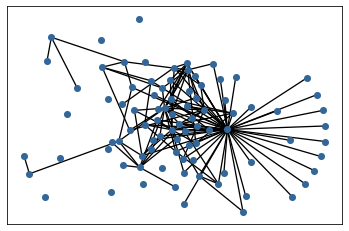

In [10]:
nx.draw_networkx_nodes(subg, pos, node_size=50,
          node_color='#336699',
          alpha=1,
          linewidths=0,
          font_size=0)
nx.draw_networkx_edges(subg, pos, alpha=1, width=1.3, edgelist=list(subg.edges)[ : 150])

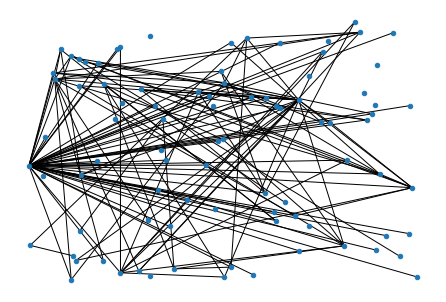

In [11]:
nx.draw_random(subg, node_size=20, edgelist=list(subg.edges)[ : 150])

In [12]:
# nxg = valid_dataset.graph.to_networkx().to_undirected()
# comps = [comp for comp in nx.connected_components(nxg) if len(comp)>10]
# print(len(comps))
# exit()

# cross_valid_list = []
# for i in range(5):
#     cross_valid_list.append(list(range(4*i, 4*(i + 1))))
# cross_train_dataset = copy.copy(train_dataset)

valid_precision = []
valid_recall = []
valid_scores = []
test_precision = []
test_recall = []
test_scores = []
# for ind, valid_list in enumerate(cross_valid_list[ : 1]):
batch_size = args.batch_size
cur_step = 0
patience = args.patience
best_score = -1
best_loss = 10000
# define loss function
loss_fcn = torch.nn.BCEWithLogitsLoss()

#         train_list = [ind for ind in range(20) if ind not in valid_list]
#         print('Train List: {}'.format(train_list))
#         print('Valid List: {}'.format(valid_list))
#         modify(train_dataset, cross_train_dataset, train_list, mode='train', offset=0)
#         modify(valid_dataset, cross_train_dataset, valid_list, mode='valid', offset=16)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)
n_classes = train_dataset.labels.shape[1]
num_feats = train_dataset.features.shape[1]
g = train_dataset.graph
heads = ([args.num_heads] * args.num_layers) + [args.num_out_heads]
# define the model
model = GAT(g,
            args.num_layers,
            num_feats,
            args.num_hidden,
            n_classes,
            heads,
            F.elu,
            args.in_drop,
            args.attn_drop,
            args.alpha,
            args.residual)
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
model = model.to(device)

for epoch in range(args.epochs):
    model.train()
    loss_list = []
    for batch, data in enumerate(train_dataloader):
        subgraph, feats, labels = data
        feats = feats.to(device)
        labels = labels.to(device)
        model.g = subgraph
        for layer in model.gat_layers:
            layer.g = subgraph
        logits = model(feats.float())
        loss = loss_fcn(logits, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_data = np.array(loss_list).mean()
    print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data), end=' ')
    if epoch % 1 == 0:
        score_list = []
        val_loss_list = []
        for batch, valid_data in enumerate(valid_dataloader):
            subgraph, feats, labels = valid_data
            feats = feats.to(device)
            labels = labels.to(device)
            prec, recall, score, val_loss = evaluate(feats.float(), model, subgraph, labels.float(), loss_fcn)
            score_list.append([prec, recall, score])
            val_loss_list.append(val_loss)
        mean_score = np.array(score_list).mean(axis=0)
        mean_val_loss = np.array(val_loss_list).mean()
        print("| Valid Precision: {:.4f} | Valid Recall: {:.4f} |  Valid F1-Score: {:.4f} ".format(mean_score[0], mean_score[1], mean_score[2]), end = ' ')

        test_score_list = []
        for batch, test_data in enumerate(test_dataloader):
            subgraph, feats, labels = test_data
            feats = feats.to(device)
            labels = labels.to(device)
            test_prec, test_rec, test_score, _ = evaluate(feats, model, subgraph, labels.float(), loss_fcn)
            test_score_list.append([test_prec, test_rec, test_score])
        mean_test_score = np.array(test_score_list).mean(axis=0)
        print("| Test Precision: {:.4f} | Test Recall: {:.4f} | Test F1-Score: {:.4f}".format(mean_test_score[0], mean_test_score[1], mean_test_score[2]))

        if epoch == args.epochs - 1:
            valid_precision.append(round(mean_score[0], 4))
            valid_recall.append(round(mean_score[1], 4))
            valid_scores.append(round(mean_score[2], 4))
            test_precision.append(round(mean_test_score[0], 4))
            test_recall.append(round(mean_test_score[1], 4))
            test_scores.append(round(mean_test_score[2], 4))

        # early stop
        if mean_score[2] > best_score or best_loss > mean_val_loss:
            if mean_score[2] > best_score and best_loss > mean_val_loss:
                val_early_loss = mean_val_loss
                val_early_score = mean_score[2]
            best_score = np.max((mean_score[2], best_score))
            best_loss = np.min((best_loss, mean_val_loss))
            cur_step = 0
        else:
            cur_step += 1
            if cur_step == patience:
                valid_precision.append(round(mean_score[0], 4))
                valid_recall.append(round(mean_score[1], 4))
                valid_scores.append(round(mean_score[2], 4))
                test_precision.append(round(mean_test_score[0], 4))
                test_recall.append(round(mean_test_score[1], 4))
                test_scores.append(round(mean_test_score[2], 4))
                break
print('Valid Scores: {}'.format(valid_scores))
print('Test Scores: {}'.format(test_scores))

out_matrix = np.stack([valid_precision, valid_recall, valid_scores, test_precision, test_recall, test_scores], axis=1)
#     np.savetxt('results.csv', out_matrix, delimiter=',')

Epoch 00001 | Loss: 2.4071 | Valid Precision: 0.6128 | Valid Recall: 0.2467 |  Valid F1-Score: 0.3518  | Test Precision: 0.6183 | Test Recall: 0.2475 | Test F1-Score: 0.3535
Epoch 00002 | Loss: 0.7400 | Valid Precision: 0.6562 | Valid Recall: 0.1973 |  Valid F1-Score: 0.3034  | Test Precision: 0.6648 | Test Recall: 0.2035 | Test F1-Score: 0.3117
Epoch 00003 | Loss: 0.5821 | Valid Precision: 0.6766 | Valid Recall: 0.2861 |  Valid F1-Score: 0.4021  | Test Precision: 0.6844 | Test Recall: 0.2871 | Test F1-Score: 0.4045
Epoch 00004 | Loss: 0.5402 | Valid Precision: 0.7210 | Valid Recall: 0.2629 |  Valid F1-Score: 0.3853  | Test Precision: 0.7273 | Test Recall: 0.2646 | Test F1-Score: 0.3881
Epoch 00005 | Loss: 0.5207 | Valid Precision: 0.7466 | Valid Recall: 0.2650 |  Valid F1-Score: 0.3912  | Test Precision: 0.7520 | Test Recall: 0.2719 | Test F1-Score: 0.3994
Epoch 00006 | Loss: 0.5071 | Valid Precision: 0.7607 | Valid Recall: 0.2591 |  Valid F1-Score: 0.3866  | Test Precision: 0.7688 | 

Epoch 00095 | Loss: 0.0119 | Valid Precision: 0.9791 | Valid Recall: 0.9560 |  Valid F1-Score: 0.9674  | Test Precision: 0.9878 | Test Recall: 0.9731 | Test F1-Score: 0.9804
Epoch 00096 | Loss: 0.0113 | Valid Precision: 0.9777 | Valid Recall: 0.9557 |  Valid F1-Score: 0.9666  | Test Precision: 0.9869 | Test Recall: 0.9722 | Test F1-Score: 0.9795
Epoch 00097 | Loss: 0.0110 | Valid Precision: 0.9759 | Valid Recall: 0.9594 |  Valid F1-Score: 0.9676  | Test Precision: 0.9855 | Test Recall: 0.9754 | Test F1-Score: 0.9804
Epoch 00098 | Loss: 0.0107 | Valid Precision: 0.9753 | Valid Recall: 0.9653 |  Valid F1-Score: 0.9703  | Test Precision: 0.9851 | Test Recall: 0.9799 | Test F1-Score: 0.9825
Epoch 00099 | Loss: 0.0115 | Valid Precision: 0.9751 | Valid Recall: 0.9641 |  Valid F1-Score: 0.9696  | Test Precision: 0.9840 | Test Recall: 0.9791 | Test F1-Score: 0.9816
Epoch 00100 | Loss: 0.0104 | Valid Precision: 0.9769 | Valid Recall: 0.9652 |  Valid F1-Score: 0.9710  | Test Precision: 0.9858 | 

In [13]:
root = 0

In [14]:
print(test_dataset.__dict__)

{'mode': 'test', 'labels': array([[1, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0]]), 'features': array([[-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       ...,
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485]]), 'graph': DGLGraph(num_nodes=5524, num_edges=167500,
         ndata_schemes={}
         edata_schemes={}), 'graph_id': array([23, 23, 23, ...,

In [15]:
testg, testlabels, testfeatures = test_dataset.graph, test_dataset.labels, test_dataset.features

In [16]:
def evaluate_tmp(feats, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.g = subgraph
        for layer in model.gat_layers:
            layer.g = subgraph
        output = model(feats.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        return output, loss_data, predict, model

In [17]:
out, loss, predict, outmodel = None, None, None, None
for batch, test_data in enumerate(test_dataloader):
    testg, testfeatures, testlabels = test_data
    testfeatures = testfeatures.to(device)
    testlabels = testlabels.to(device)
    out, loss, predict, outmodel = evaluate_tmp(testfeatures, model, testg, testlabels, loss_fcn)

In [18]:
print(len(outmodel.gat_layers))
g1, g2, g3, g4 = outmodel.gat_layers[0].graph, outmodel.gat_layers[1].graph, outmodel.gat_layers[2].graph, outmodel.gat_layers[3].graph

4


In [ ]:
print(tmpg.all_edges())

In [ ]:
tmpg.edata['a']

In [ ]:
print(tmpg.edata['a'])

In [19]:
gnx1 = g1.to_networkx(node_attrs=['ft'], edge_attrs=['a']).to_undirected()
gnx2 = g2.to_networkx(node_attrs=['ft'], edge_attrs=['a']).to_undirected()
gnx3 = g3.to_networkx(node_attrs=['ft'], edge_attrs=['a']).to_undirected()
gnx4 = g4.to_networkx(node_attrs=['ft'], edge_attrs=['a']).to_undirected()

In [20]:
print(len(list(gnx1.nodes)))

5524


In [21]:
import random
import matplotlib.colors as cl
import matplotlib.cm as cm

In [22]:
# root = random.choice(list(gnx1.nodes))
root = 0
edg_list = list(nx.bfs_edges(gnx1, root, depth_limit=2))
print(len(edg_list))
tnodes = [root] + [v for u, v in edg_list]
print(len(tnodes))

1261
1262


In [23]:
selected_nodes = tnodes[ : 100]
subg1 = gnx1.subgraph(selected_nodes)
subg2 = gnx2.subgraph(selected_nodes)
subg3 = gnx3.subgraph(selected_nodes)
subg4 = gnx4.subgraph(selected_nodes)
# print(list(subg.nodes))
print(len(list(subg1.edges)))

665


In [24]:
pos = nx.spring_layout(subg1, k=1 / np.sqrt(subg1.number_of_nodes()), iterations=100)

In [41]:
lst = []
for edge in subg4.edges.data():
    lst.append(edge[2]['a'][5].item())
print(min(lst), max(lst))

minima = min(lst)
maxima = max(lst)

norm = cl.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='PuBuGn')

lstc = []
for v in lst:
    lstc.append(mapper.to_rgba(v))

2.5138381625244423e-31 0.9999828338623047


Text(0.5, 1.0, '$4^{th}$ Layer Attention Weights')

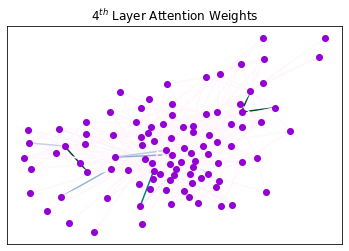

In [42]:
nx.draw_networkx_nodes(subg2, pos, node_size=50,
          node_color='darkviolet',
          alpha=1,
          linewidths=0,
          font_size=0)
nx.draw_networkx_edges(subg1, pos, alpha=1, width=1.5, edgelist=list(subg1.edges), edge_color=lstc)
plt.title(r'$4^{th}$ Layer Attention Weights')
# plt.savefig('layer4.png', bbox_inches='tight', dpi=1000)

In [ ]:
import matplotlib.colors as cl
import matplotlib.cm as cm
minima = min(lst2)
maxima = max(lst2)

norm = cl.Normalize(vmin=minima, vmax=maxima, clip=False)
mapper = cm.ScalarMappable(norm=norm, cmap='Wistia')
print(mapper)

In [ ]:
lstc = []
for v in lst2:
    lstc.append(mapper.to_rgba(v))
# print(lst2)

In [ ]:
nx.draw_networkx_nodes(subg, pos, node_size=50,
          node_color='#336699',
          alpha=1,
          linewidths=0,
          font_size=0)
nx.draw_networkx_edges(subg, pos, alpha=1, width=1.3, edgelist=list(subg.edges)[ : 500], edge_color = lstc)

In [ ]:
print(lstc)

In [46]:
from collections import defaultdict

In [117]:
num_heads = 4
entropy = np.zeros((gnx3.number_of_nodes(), num_heads))

for edge_data in gnx3.edges.data():
    head = edge_data[0]
    tail = edge_data[1]
    for i in range(num_heads):
        val = edge_data[2]['a'][i].item()
        entropy[head][i] -= val * np.log2(val)
        entropy[tail][i] -= val * np.log2(val)

In [118]:
print(entropy)

[[4.1485437  4.17013695 3.01360636 0.27815621]
 [2.01598459 0.51050366 0.90714859 1.83267297]
 [1.51529276 2.51361823 1.3799799  1.02961091]
 ...
 [1.26180267 1.38660455 0.2498976  0.97588627]
 [0.62058698 2.24920881 0.53258319 0.55481134]
 [0.269893   0.5117345  1.4285497  0.12716643]]


In [119]:
import math

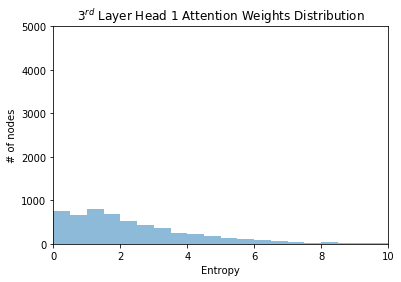

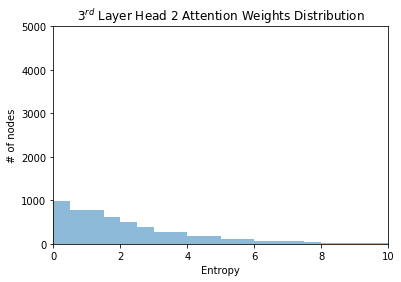

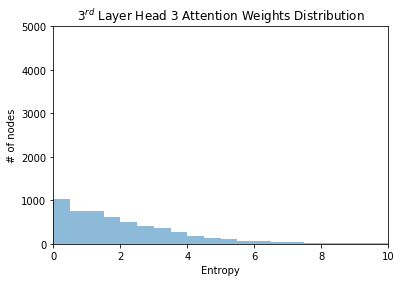

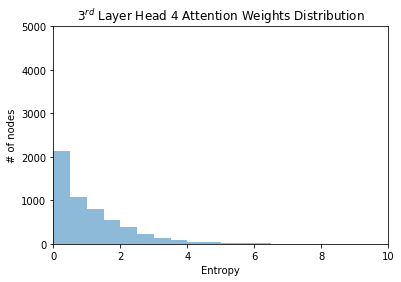

In [120]:
for i in range(num_heads):
    data = entropy[:, i]
    bins = np.arange(math.ceil(min(data)), 
                   math.floor(max(data)),
                   0.5)
    plt.figure()
    plt.xlim([0, 10])
    plt.ylim([0, 5000])
    plt.hist(data, bins=bins, alpha=0.5)
    plt.title(r'$3^{rd}$ Layer Head ' +  '{} Attention Weights Distribution'.format(i + 1))
    plt.xlabel('Entropy')
    plt.ylabel('# of nodes')
    plt.savefig('entropy_hidden3_head{}.png'.format(i + 1), bbox_inches='tight', dpi=1000)

In [121]:
uniform_entropy = np.zeros(gnx4.number_of_nodes())
for node in gnx4.nodes:
    uniform_entropy[node] = np.log2(gnx4.degree[node])
print(uniform_entropy)

[4.39231742 2.         4.70043972 ... 3.80735492 2.5849625  3.9068906 ]


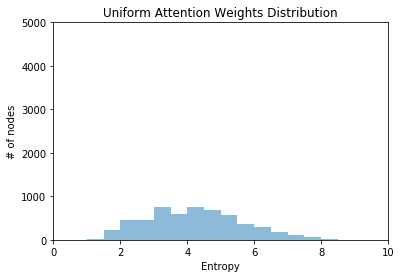

In [123]:
data = uniform_entropy
bins = np.arange(math.ceil(min(data)), 
                   math.floor(max(data)),
                   0.5)
plt.figure()
plt.xlim([0, 10])
plt.ylim([0, 5000])
plt.hist(data, bins=bins, alpha=0.5)
plt.title('Uniform Attention Weights Distribution')
plt.xlabel('Entropy')
plt.ylabel('# of nodes')
plt.savefig('entropy_uniform.png', bbox_inches='tight', dpi=1000)

In [149]:
lst = []
for node_data in gnx3.nodes.data():
    lst.append(list(node_data[1]['ft'][3].cpu()))
print(len(lst), len(lst[0]))

5524 256


In [150]:
lst = np.array(lst)

In [151]:
from sklearn.manifold import TSNE

In [152]:
lst_modified = TSNE(n_components=2, verbose=1, n_jobs=6).fit_transform(lst)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5524 samples in 0.142s...
[t-SNE] Computed neighbors for 5524 samples in 7.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5524
[t-SNE] Computed conditional probabilities for sample 2000 / 5524
[t-SNE] Computed conditional probabilities for sample 3000 / 5524
[t-SNE] Computed conditional probabilities for sample 4000 / 5524
[t-SNE] Computed conditional probabilities for sample 5000 / 5524
[t-SNE] Computed conditional probabilities for sample 5524 / 5524
[t-SNE] Mean sigma: 16.753422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.111031
[t-SNE] KL divergence after 1000 iterations: 1.237451


In [153]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
print(sns.__version__)

0.8.1


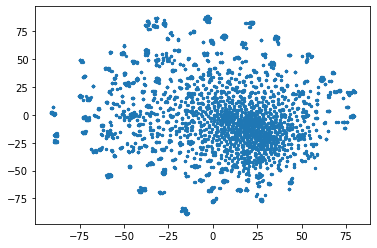

In [154]:
plt.figure()
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=lst_modified,
#     legend="full",
#     alpha=0.3
# )
plt.scatter(lst_modified[:, 0], lst_modified[:, 1], s=5)

In [157]:
from copy import deepcopy

In [163]:
tmpg = deepcopy(gnx1)

In [164]:
# tmpg.remove_nodes_from(list(nx.isolates(tmpg)))

comps = [tmpg.subgraph(comp) for comp in nx.connected_components(tmpg) if len(comp) > 10]
tmpg = comps[0]
tmpg2 = comps[1]

In [165]:
pos = nx.spring_layout(tmpg, k=1 / np.sqrt(tmpg.number_of_nodes()), iterations=100)

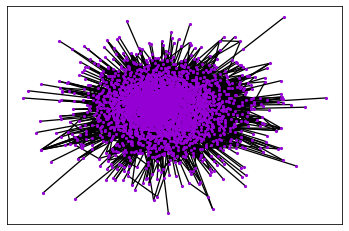

In [167]:
nx.draw_networkx_nodes(tmpg, pos, node_size=10,
          node_color='darkviolet',
          alpha=1,
          linewidths=0,
          font_size=0)
nx.draw_networkx_edges(tmpg, pos, alpha=1, width=1.3)

In [168]:
print(test_dataset.__dict__)

{'mode': 'test', 'labels': array([[1, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0]]), 'features': array([[-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       ...,
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485],
       [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
        -0.14936616, -0.14811485]]), 'graph': DGLGraph(num_nodes=5524, num_edges=167500,
         ndata_schemes={}
         edata_schemes={}), 'graph_id': array([23, 23, 23, ...,

In [169]:
lb = test_dataset.labels

In [170]:
print(lb.shape)

(5524, 121)


In [174]:
print(np.sum(lb, axis=1))

[31  8 15 ... 46 68 36]


In [175]:
print(np.mean(np.sum(lb, axis=1)))

36.22302679217958


In [177]:
np.max(np.sum(lb, axis=1))

101